### This script takes in tracking results in MOT format for sequence and visualize cropped instances of individual targets from different frames.

In [4]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
import torch
import sys

from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sys.path.append(r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\TrackLink\reid\torchreid\utils")
from feature_extractor import FeatureExtractor

In [2]:
res_path = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\SportsMOT\Sort_Results\Sort_Baseline\v_6OLC1-bhioc_c001.txt" # path to tracking results

seq_name = os.path.basename(res_path).split(".txt")[0]
# seq_data_dir = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\SoccerNet\tracking-2023\test\SNMOT-116" # path to specific sequence with directories img1, dets, gt
# data_dir = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\SoccerNet\tracking-2023\test"
data_dir = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\SportsMOT\dataset\test"
split = os.path.basename(data_dir)
assert split in ("train", "test", "challenge")
seq_data_dir = os.path.join(data_dir, seq_name)
img_dir = os.path.join(seq_data_dir, "img1")
split = os.path.basename(split)
if "SoccerNet" in seq_data_dir:
    dataset = "SoccerNet"
elif "SportsMOT" in seq_data_dir:
    dataset = "SportsMOT"
else:
    dataset = None
assert dataset in ("SoccerNet", "SportsMOT")
# save_dir = os.path.join(seq_data_dir, "..", "..", "_temp", f"visualization", seq_name) # create path to save directory, vizualiation->seq_name
save_dir = os.path.join("..", "_temp", "visualization", dataset, seq_name)
os.makedirs(save_dir, exist_ok=True)
# TODO: 
# load tracking resutls in dataframe
# for each image frame in img1:
#   query results for the frame
#   create folder for each new track id
#   save cropped image of target in track id folder, save the file with the same name as image(i.e.f'{frame_id}.jpg')
track_res = np.genfromtxt(res_path, dtype=float, delimiter=',')
# NOTE: MOT format <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>

max_frame_id = int(np.max(track_res[:, 0]))

for frame_id in tqdm(range(1, max_frame_id + 1), desc="Processing Frames"):
    img_fname = f"{frame_id:06d}.jpg"
    img_path = os.path.join(img_dir, img_fname)
    img = Image.open(img_path)
    frame_dets = track_res[track_res[:, 0] == frame_id]
    # TODO:
    # for each line of detection
    #   get track_id, create folder save_dir + {track_id}
    #   crop instance and save to created folder with img_fname
    seen_tid = set()
    for _, track_id, l, t, w, h, _, _, _, _ in frame_dets:
        
        tid_dir = os.path.join(save_dir, f"{track_id:.0f}")
        if track_id not in seen_tid:
            os.makedirs(tid_dir, exist_ok=True)
            seen_tid.add(track_id)
        instance_im = img.crop((l, t, l+w, t+h))
        # save the instance_im
        instance_im.save(os.path.join(tid_dir, img_fname))
    # break

Processing Frames: 100%|██████████| 1126/1126 [00:20<00:00, 54.06it/s]


### Code below takes in image instances of one resulting tracklet and calculates inner cosine distance of 

Successfully loaded pretrained weights from "C:\Users\Ciel Sun\OneDrive - UW\EE 599\TrackLink\checkpoints\sports_model.pth.tar-60"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
(49, 512)


c:\Users\Public\anaconda3\envs\TrackLink-2\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


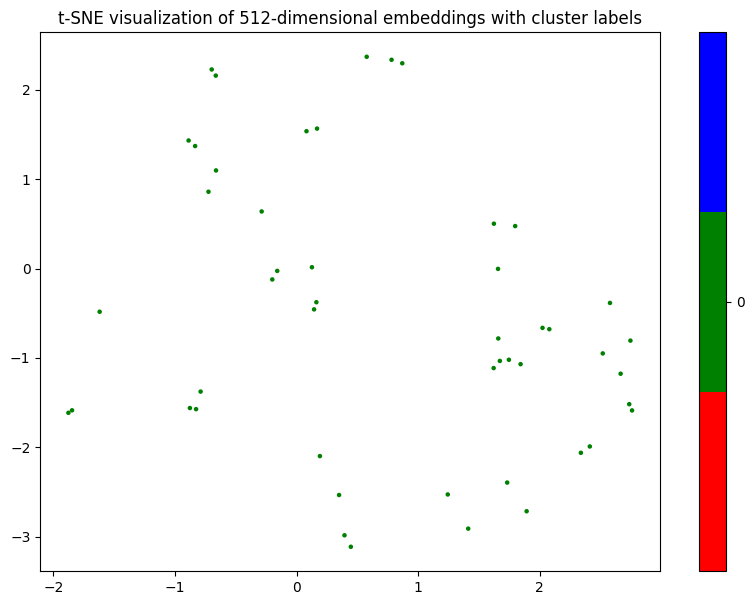

Average Inner Distance: 0.22041986425549365
Identity Switch Detected: False


In [22]:
def get_avg_inner_distance(embs):
    """
    Calculates the average inner cosine distance for a set of embeddings. This measure assesses the
    compactness or consistency of the embeddings within a tracklet, helping to decide if the tracklet
    should be split.

    This function is designed to handle large sets of embeddings efficiently. If the number of embeddings
    exceeds a certain threshold (e.g., 15,000), the embeddings are subsampled to fit within memory constraints
    before calculating the distance.

    Args:
        embs (list of numpy arrays): A list where each element is a numpy array representing an embedding.
                                     Each embedding has the same dimensionality.

    Returns:
        float: The average cosine distance between all pairs of embeddings in the list.
    """
    while len(embs) > 15000: # GPU memory limit
        embs = embs[1::2]
    embs = np.stack(embs)
    torch_embs = torch.from_numpy(embs).cuda()
    torch_embs = torch.nn.functional.normalize(torch_embs, dim=1)
    similarity_matrix = torch.matmul(torch_embs, torch_embs.t())
    n = similarity_matrix.shape[0]
    average_cosine_distance = 1 - (similarity_matrix.sum() - similarity_matrix.diag().sum()) / (n * (n - 1))
    return average_cosine_distance

def visualize_embeddings(embs, labels, perplexity=30, n_iter=1000, random_state=None):
    """
    Visualizes high-dimensional embeddings in 2D space using t-SNE.

    Args:
        embs (numpy array): A numpy array of shape (n, 512) where n is the number of samples.
        perplexity (int): The perplexity parameter for t-SNE.
        n_iter (int): The number of iterations for t-SNE optimization.
        random_state (int): The random seed for reproducibility.

    Returns:
        None
    """
    # Check if embeddings are in the correct shape
    assert embs.ndim == 2 and embs.shape[1] == 512, "Input embeddings should be of shape (n, 512)."
    assert labels.ndim == 1 and labels.shape[0] == embs.shape[0], "Labels should be of shape (n,)."


    scaler = StandardScaler()
    embs = scaler.fit_transform(embs)
    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    embs_2d = tsne.fit_transform(embs)

    # Define a list of colors
    colors = ['red', 'green', 'blue']
    cmap = ListedColormap(colors)

    # Plot the 2D embeddings with colors based on cluster labels
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embs_2d[:, 0], embs_2d[:, 1], c=labels, s=5, cmap=cmap)
    plt.colorbar(scatter, ticks=np.unique(labels))
    plt.title('t-SNE visualization of 512-dimensional embeddings with cluster labels')
    plt.show()

def detect_id_switch(embs, eps=0.5, min_samples=5, max_clusters=3):
    """
    Detects identity switches within a tracklet using clustering.

    Args:
        embs (list of numpy arrays): A list where each element is a numpy array representing an embedding.
                                     Each embedding has the same dimensionality.
        eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        bool: True if an identity switch is detected, otherwise False.
    """
    if len(embs) > 15000:
        embs = embs[1::2]

    embs = np.stack(embs)
    
    # Standardize the embeddings
    scaler = StandardScaler()
    embs_scaled = scaler.fit_transform(embs)

    # Apply DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(embs_scaled)
    labels = db.labels_
    
    # Count the number of clusters (excluding noise)
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]

    if -1 in labels:
        # Find the cluster centers
        cluster_centers = np.array([embs_scaled[labels == label].mean(axis=0) for label in unique_labels])
        
        # Assign noise points to the nearest cluster
        noise_indices = np.where(labels == -1)[0]
        for idx in noise_indices:
            distances = cdist([embs_scaled[idx]], cluster_centers, metric='cosine')
            nearest_cluster = np.argmin(distances)
            labels[idx] = list(unique_labels)[nearest_cluster]
    
    n_clusters = len(unique_labels)

    if n_clusters > max_clusters:
        # Merge clusters to ensure the number of clusters does not exceed max_clusters
        while n_clusters > max_clusters:
            cluster_centers = np.array([embs_scaled[labels == label].mean(axis=0) for label in unique_labels])
            distance_matrix = cdist(cluster_centers, cluster_centers, metric='cosine')
            np.fill_diagonal(distance_matrix, np.inf)  # Ignore self-distances
            
            # Find the closest pair of clusters
            min_dist_idx = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)
            cluster_to_merge_1, cluster_to_merge_2 = unique_labels[min_dist_idx[0]], unique_labels[min_dist_idx[1]]

            # Merge the clusters
            labels[labels == cluster_to_merge_2] = cluster_to_merge_1
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[unique_labels != -1]
            n_clusters = len(unique_labels)

    return n_clusters > 1, labels

def detect_id_switch_HDBSCAN(embs, min_cluster_size=5, min_samples=None, max_clusters=3):
    """
    Detects identity switches within a tracklet using clustering.

    Args:
        embs (list of numpy arrays): A list where each element is a numpy array representing an embedding.
                                     Each embedding has the same dimensionality.
        eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        bool: True if an identity switch is detected, otherwise False.
    """
    if len(embs) > 15000:
        embs = embs[1::2]

    embs = np.stack(embs)
    
    # Standardize the embeddings
    scaler = StandardScaler()
    embs_scaled = scaler.fit_transform(embs)

    # Apply DBSCAN clustering
    hdb = HDBSCAN(min_cluster_size=min_cluster_size, 
                  min_samples=min_samples, 
                  metric='cosine', 
                  allow_single_cluster=True).fit(embs_scaled)
    labels = hdb.labels_
    # cluster_centers = hdb.centroids_
    # Count the number of clusters (excluding noise)
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]

    # if -1 in labels:
    #     # Find the cluster centers
    #     cluster_centers = np.array([embs_scaled[labels == label].mean(axis=0) for label in unique_labels])
        
    #     # Assign noise points to the nearest cluster
    #     noise_indices = np.where(labels == -1)[0]
    #     for idx in noise_indices:
    #         distances = cdist([embs_scaled[idx]], cluster_centers, metric='cosine')
    #         nearest_cluster = np.argmin(distances)
    #         labels[idx] = list(unique_labels)[nearest_cluster]
    
    n_clusters = len(unique_labels)

    # if n_clusters > max_clusters:
    #     # Merge clusters to ensure the number of clusters does not exceed max_clusters
    #     while n_clusters > max_clusters:
    #         cluster_centers = np.array([embs_scaled[labels == label].mean(axis=0) for label in unique_labels])
    #         distance_matrix = cdist(cluster_centers, cluster_centers, metric='cosine')
    #         np.fill_diagonal(distance_matrix, np.inf)  # Ignore self-distances
            
    #         # Find the closest pair of clusters
    #         min_dist_idx = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)
    #         cluster_to_merge_1, cluster_to_merge_2 = unique_labels[min_dist_idx[0]], unique_labels[min_dist_idx[1]]

    #         # Merge the clusters
    #         labels[labels == cluster_to_merge_2] = cluster_to_merge_1
    #         unique_labels = np.unique(labels)
    #         unique_labels = unique_labels[unique_labels != -1]
    #         n_clusters = len(unique_labels)

    return n_clusters > 1, labels

val_transforms = T.Compose([T.Resize([256, 128]),
                            T.ToTensor(),
                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ])

extractor = FeatureExtractor(model_name='osnet_x1_0',
                            model_path = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\TrackLink\checkpoints\sports_model.pth.tar-60",
                            device='cuda'
                            )
# Good example
# img_dir = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\TrackLink\track-link\_temp\visualization\SportsMOT\v_2BhBRkkAqbQ_c002\4617_idsw"
img_dir = r"C:\Users\Ciel Sun\OneDrive - UW\EE 599\TrackLink\track-link\_temp\visualization\SportsMOT\v_2BhBRkkAqbQ_c002\4645_jersey53"
embs = []
for im_path in [os.path.join(img_dir, im) for im in os.listdir(img_dir) if im.endswith(".jpg")]:
    im = Image.open(im_path)
    im = val_transforms(im.convert('RGB')).unsqueeze(0)
    features = extractor(im)
    feat = features.cpu().detach().numpy().tolist()
    embs += feat


print(np.array(embs).shape)

average_distance = get_avg_inner_distance(embs)
id_switch_detected, clusters = detect_id_switch(embs, min_samples=10, eps=0.6)
# id_switch_detected, clusters = detect_id_switch_HDBSCAN(embs, min_cluster_size=4, max_clusters=3)

visualize_embeddings(np.array(embs), clusters)

print(f"Average Inner Distance: {average_distance}")
print(f"Identity Switch Detected: {id_switch_detected}")
if id_switch_detected:
    print(np.unique(clusters, return_counts=True))
    print(f"Clusters: {clusters}")